# Prediction of bike rental count hourly based on the environmental and seasonal settings.



**Github**: https://github.com/lucaskvz/AI-MACHINE-LEARNING-FOUNDATIONS.git

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Task 1: Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv("data/hour.csv") # This DF is reserved for model training 
dfEDA = df.copy() # This is a copy of the dataframe I will use to do eda I realsied that I should have include this in the beggining 
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# First I want to look at the number of rows and columns
print(f"Dataset Shape:{dfEDA.shape}") 

Dataset Shape:(17379, 17)


**Examine the target variable (cnt) distribution and identify its skewness**

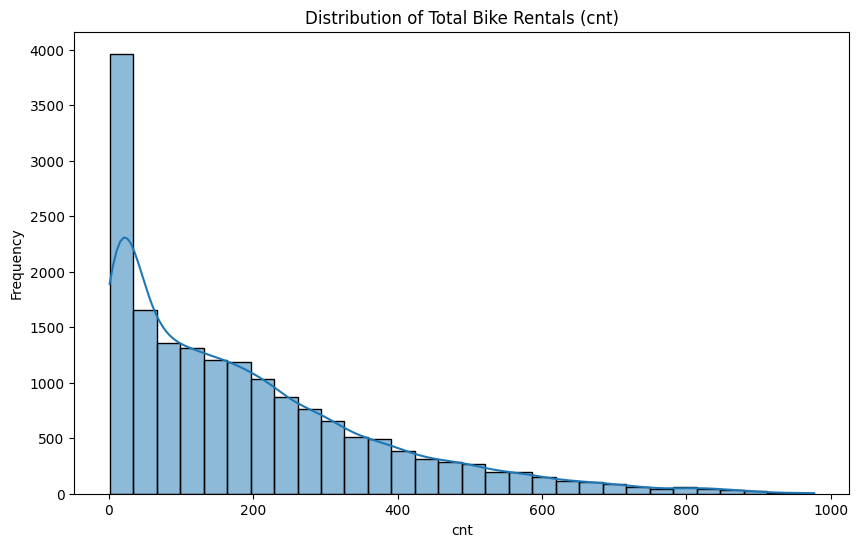

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(dfEDA['cnt'], kde=True, bins=30)
plt.title('Distribution of Total Bike Rentals (cnt)')
plt.xlabel('cnt')
plt.ylabel('Frequency')
plt.show()


What this tells me?
- Most common hourly rental counts where in the low range (200/6 = 33.33) 0-33 or 0-66 up till 200 where it starts to taper off faster
- Fewer hours had higher rentals indicating the data is postivley skewed -> most people rented bikes in small numbers per hour, but sometimes there where peak hours with lots of rentals

What should I do with this information:
- Could possibly look into a log transformation to make the target variable more normally distributed. For linear regression, it better meets assumptions like normality and constant variance. Features would remain the same but relationships become multiplicative. I would need to look into how this would impact the tree based models before proceeding with something like this...

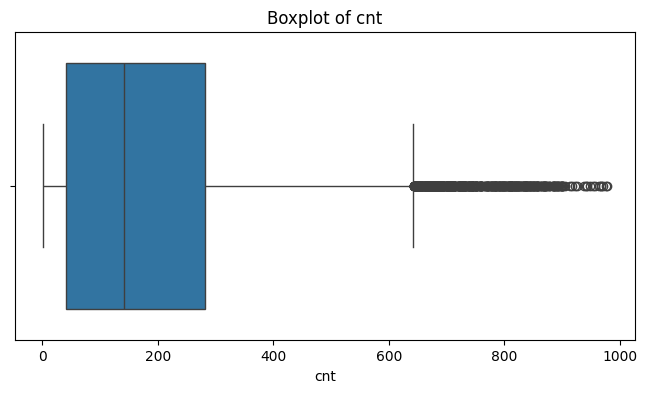

In [5]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=dfEDA['cnt'])
plt.title('Boxplot of cnt')
plt.show()


The boxplot visually supports the earlier histogram: most bike rentals per hour are low, with a long tail of rare high usage hours.

It is important to manage these outliers as they can distor the linear regression model but as I understand it not affect the treebased models too greatly. 

In [6]:
cnt_skew = skew(dfEDA['cnt'])
print(f"Skewness of cnt: {cnt_skew:.2f}")


Skewness of cnt: 1.28


The histogram and boxplot of cnt show a strong right skew, with most hourly bike rental counts concentrated at lower values and a long tail of high values. This visual observation is confirmed by the skewness value of 1.28, indicating moderate - high positive skewness

**Explore analytically the influence of temporal (hr, weekday, mnth, season), binary (holiday, workingday),and weather-related features (temp, atemp, hum, windspeed, weathersit) on cnt**

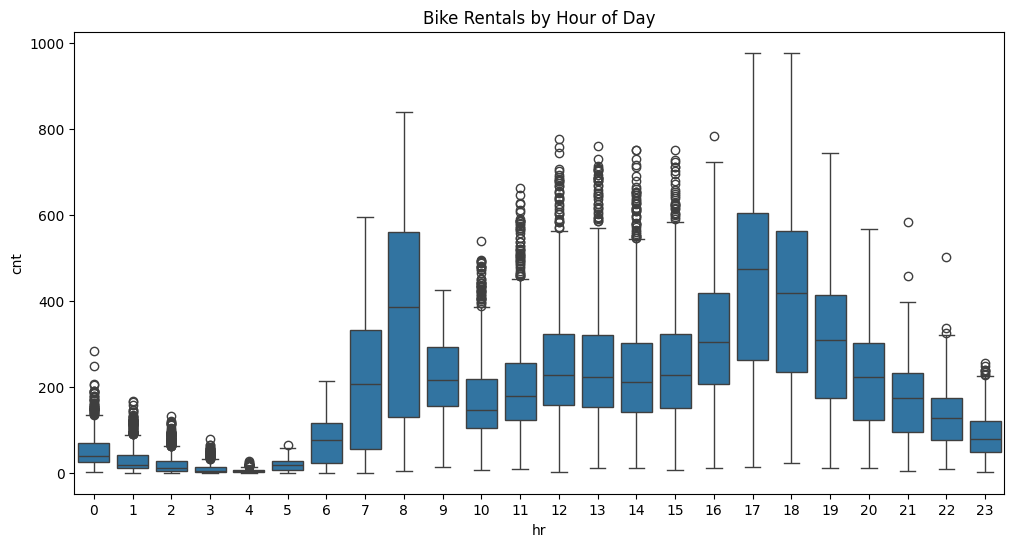

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Hour of Day')
plt.show()


Insights:
- Peak hours: 8 am and 17-18 coinciding with commute times likley
- Late night and early morning show low rentals
- Midday hours have moderate rentals suggesting casual usage likley tourism/non-commute usage

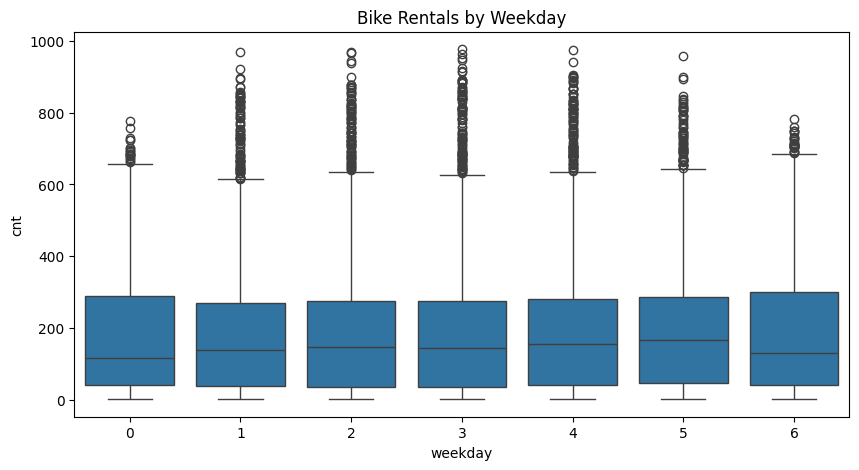

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Weekday')
plt.show()



Take aways:
- Rental patterns are fairly consistent across all weekdays, with no dramatic differences in median or spread
- Weekdays 1-5 have slightly higher medians than weekends suggesting commuting usage
- Presence of consistent outliers across all weekdays reinforces the idea that the hour of the day and external conditions drive spikes more than the day itself

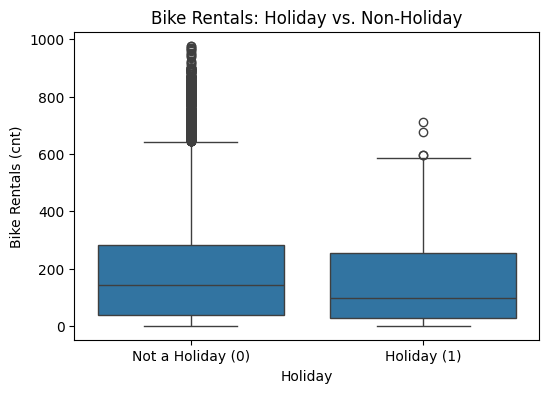

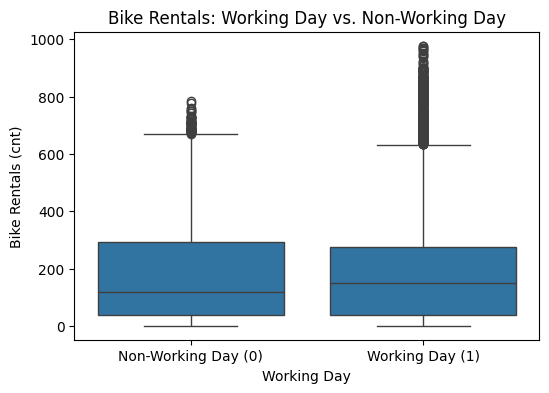

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='holiday', y='cnt', data=dfEDA)
plt.title('Bike Rentals: Holiday vs. Non-Holiday')
plt.xticks([0, 1], ['Not a Holiday (0)', 'Holiday (1)'])  # Custom labels
plt.xlabel('Holiday')
plt.ylabel('Bike Rentals (cnt)')
plt.show()

# Working day plot with clear labels
plt.figure(figsize=(6, 4))
sns.boxplot(x='workingday', y='cnt', data=dfEDA)
plt.title('Bike Rentals: Working Day vs. Non-Working Day')
plt.xticks([0, 1], ['Non-Working Day (0)', 'Working Day (1)'])  # Custom labels
plt.xlabel('Working Day')
plt.ylabel('Bike Rentals (cnt)')
plt.show()


**Holiday vs. Non-Holiday**
- median rentals are slightly lower on holidays (1), suggesting less commuting and more unpredicatble usage
- More outliers exist on non-holidays 
- Insight -> holidays leads to reduced demand due to people possibly staying home or having altered routines

**Working Day vs. Non-Working Day**
- Working days show higher median bike rentals, confirming commuting patterns indicate usage.
- Wider spread on working days, indicating busier and more variable activity
- Insight -> workingday is likley a stronger predictor of bike demand than holiday due to routine behaviors

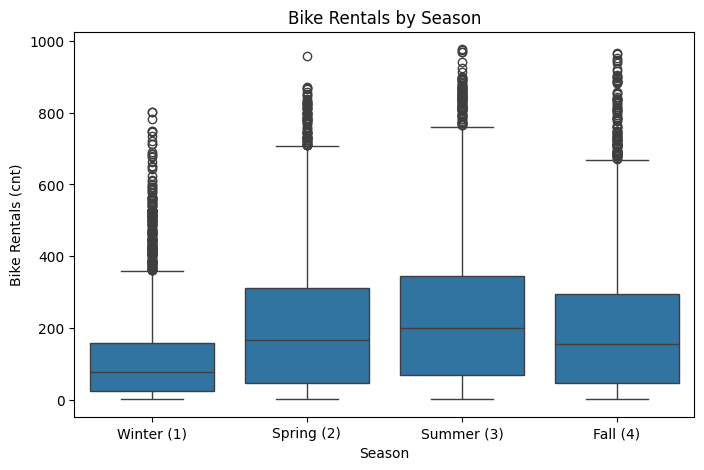

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='season', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Bike Rentals (cnt)')
plt.xticks([0, 1, 2, 3], ['Winter (1)', 'Spring (2)', 'Summer (3)', 'Fall (4)'])  # Adjust if needed
plt.show()


Summer (3) has the highest median number of bike rentals, with a wide spread and many high outliers. people ride more in warmer months.

Spring (2) and Fall (4) follow closely behind, with slightly lower medians but still strong usage. these are transitional seasons with favorable weather.

Winter (1) has the lowest median and overall rental count. cold weather likely discourages bike usage.

All seasons show outliers, but summer has the most extreme high values, suggesting occasional spikes in bike usage (e.g. weekends, events, holidays).


In [11]:
# Correlation with cnt
weather_features = ['temp', 'atemp', 'hum', 'windspeed']
dfEDA[weather_features + ['cnt']].corr()['cnt'].sort_values(ascending=False)


cnt          1.000000
temp         0.404772
atemp        0.400929
windspeed    0.093234
hum         -0.322911
Name: cnt, dtype: float64

temp: Moderate positive correlation → As temperature increases, bike rentals tend to increase. Makes sense: people ride more when it's nice out.

atemp: since it represents perceived temperature. Slightly lower but very close.

windspeed: Very weak positive correlation → Wind doesn't seem to strongly affect rental behavior, or its effect may be more nonlinear (e.g., light breeze is fine, strong wind deters riding).

hum: Moderate negative correlation → Higher humidity tends to decrease bike usage.

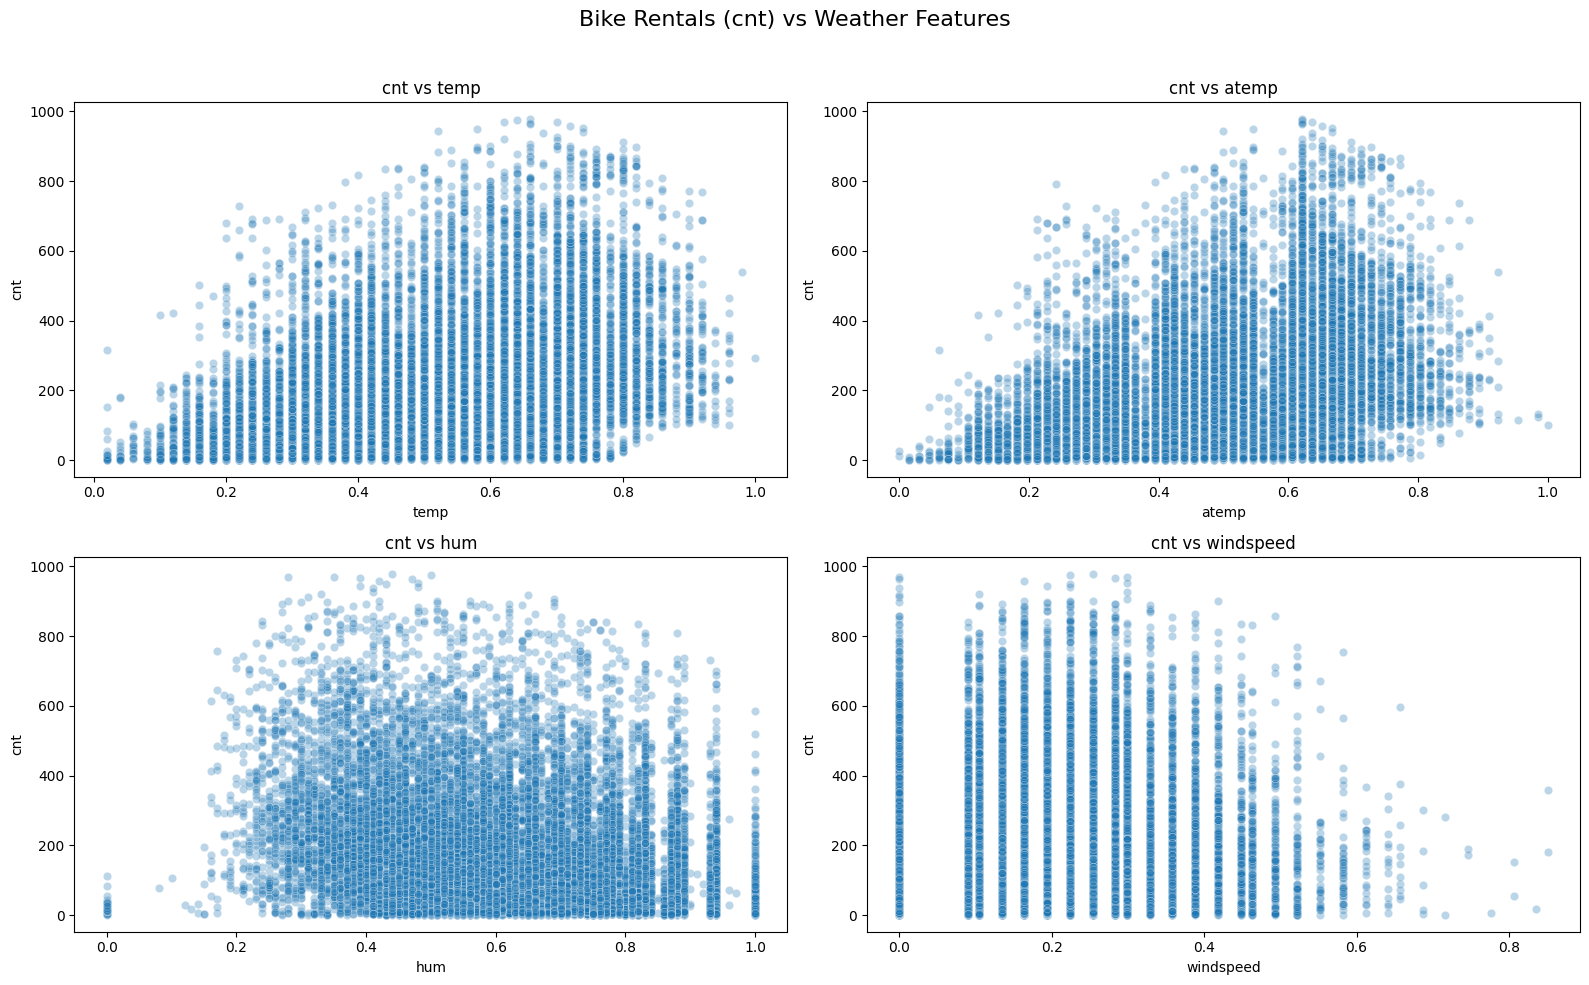

In [12]:
weather_features = ['temp', 'atemp', 'hum', 'windspeed']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(weather_features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=dfEDA[feature], y=dfEDA['cnt'], alpha=0.3)
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.suptitle('Bike Rentals (cnt) vs Weather Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**cnt vs temp / atemp**
- Strong upward trend up to ~0.7–0.8 -> more bike rentals as temperature rises.
- But it plateaus or slightly drops after that — possibly too hot to ride comfortably.

**cnt vs hum**
Very scattered no strong trend. Slight negative pattern visible: high humidity may discourage rentals

**cnt vs windspeed**
Also weak perhaps mild wind is fine, but strong wind reduces rentals, visible as a drop past 0.4.

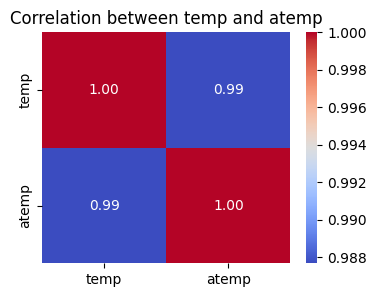

In [13]:
# Correlation matrix for temp and atemp
corr_matrix = dfEDA[['temp', 'atemp']].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between temp and atemp')
plt.show()


- atemp and temp provide almost identical information 
- Including both features adds redundant information 
- To avoid multicollinearity in linear regression and unnecessary complexity in the tree based models I will drop atemp


In [14]:
#dropping it from my ML dataframe called df and not my eda dataframe
df.drop(columns=['atemp'], inplace = True)

In [15]:
df.drop(columns=['instant'], inplace=True) # as its just a row index with no predictive power

df.drop(columns=['dteday'], inplace=True) # is the data column we already have yr, mnth, weekday, and hr which extract date info

df.drop(columns=['casual', 'registered'], inplace=True) # data leakage


**Further reasoning:**
- casual and registered:
    - cnt = Count of total rental bikes including both casual and registered users
    - Including them would leak target info into the model thus it must be dropped

In [16]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


# Task 2: Data Splitting

You reccomended -> "Use a random split while preserving temporal order if possible" which sounds a bit contradictory but this is how I interpreted it...

Chuncked and Random Approach:
- I will split the dataset into training (60%), validation (20%), and test (20%) sets. 
- To preserve the temporal structure of the data, I will keep the final 20% (the most recent records) as the test set to simulate how the model would perform on future, unseen data. 
- From the remaining 80%, I will randomly split the data into training and validation sets using stratification by season. 
- This will ensure that both sets contain a balanced mix of seasonal patterns. By doing this, I aim to avoid data leakage, respect the chronological nature of the dataset, and help the model generalize better across different seasonal conditions.



In [17]:
# Get total rows
n = len(df)

# Keep the last 20% of the data as your test set (chronologically last)
df_test = df.iloc[int(n * 0.8):].copy()     # Final 20%
df_temp = df.iloc[:int(n * 0.8)].copy()     # First 80% to use for train and val

# Randomly split the first 80% into training and validation,
# stratified by 'season' to preserve seasonal balance
df_train, df_val = train_test_split(
    df_temp,
    test_size=0.25,                         # 25% of 80% = 20% overall
    stratify=df_temp['season'],            # Even seasonal distribution
    random_state=42
)


In [18]:
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

total_rows = len(df)
print("Total:", total_rows)
print("Train %:", round(len(df_train) / total_rows * 100, 2))
print("Val %:", round(len(df_val) / total_rows * 100, 2))
print("Test %:", round(len(df_test) / total_rows * 100, 2))


Train shape: (10427, 12)
Validation shape: (3476, 12)
Test shape: (3476, 12)
Total: 17379
Train %: 60.0
Val %: 20.0
Test %: 20.0


In [19]:
# Check if any indices overlap
print("Overlap between train and val:", df_train.index.intersection(df_val.index).any())
print("Overlap between train and test:", df_train.index.intersection(df_test.index).any())
print("Overlap between val and test:", df_val.index.intersection(df_test.index).any())


Overlap between train and val: False
Overlap between train and test: False
Overlap between val and test: False


In [20]:
print("Train season distribution:\n", df_train['season'].value_counts(normalize=True))
print("\nValidation season distribution:\n", df_val['season'].value_counts(normalize=True))


Train season distribution:
 season
2    0.317157
1    0.286276
3    0.243119
4    0.153448
Name: proportion, dtype: float64

Validation season distribution:
 season
2    0.317031
1    0.286249
3    0.243096
4    0.153625
Name: proportion, dtype: float64


Now that I have validated the my data splitting has worked.... I want to again justfiy my reasoning for choosing this approach:

Advantages:
- Preserves temporal order in the test set:
    - By setting aside the last 20% of the dataset for testing, I simulate a real-world scenario where the model is evaluated on future, unseen data
- Introduces randomness in train/val:
    - Within the past 80%, I apply a randomized split to help the model generalize better and avoid overfitting to a narrow time window.
- Stratified by season:
    - I stratified the training and validation split by the season feature to ensure seasonal patterns are fairly represented in both sets.
- Prevents data leakage:
    - The test set is untouched until final evaluation, reducing the risk of data leakage and helping me evaluate true model performance.

Disadvantages (and how I can address them...):
- Train/validation split may mix unrelated time periods
    - Although season stratification helps, it doesn’t guarantee balanced representation of months or holidays. This could be improved by stratifying on both season and mnth, or by creating custom groups that include holiday information.
- Validation set lacks strict temporal order
    - Random sampling can blur evolving time trends. A potential improvement would be to use time-aware validation methods, such as rolling or expanding windows, or apply chronological splits while preserving seasonal balance.
- Within-season trends may be missed
    - Stratifying by season alone may overlook differences within a season (e.g., early vs. late summer). To capture finer patterns, features like season_phase or combinations of month and week could be introduced.

Depending on the performance and generalization ability of the models, I may revisit and refine this data splitting strategy



# Task 3: Feature Engineering

The features hr (hour of day) and weekday are cyclical, meaning their values repeat in a fixed cycle (e.g., hour 23 is followed by hour 0). Using raw numerical values would mislead the model into interpreting adjacent values as far apart. 

To preserve this cyclical structure, I apply sine and cosine transformations to both features. I chose to perform this transformation directly on the split dataframes (df_train, df_val, and df_test) rather than after defining X and y to ensure that no information from the validation or test sets leaks into the training process. By applying transformations at the dataframe level, I avoid the complexity of repeating the same logic across X_train, X_val, and X_test, and reduce the risk of introducing mistakes or inconsistencies later in the pipeline.

In [21]:
# Function to encode a cyclical feature using sine and cosine
def encode_cyclical(df, column, max_val):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

# Apply to all three datasets
for dataset in [df_train, df_val, df_test]:
    dataset = encode_cyclical(dataset, 'hr', 24)        # hour of day: 0–23
    dataset = encode_cyclical(dataset, 'weekday', 7)    # weekday: 0–6


In [22]:
print(df_train.columns)
print(df_train[['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos']].describe())

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'hr_sin', 'hr_cos',
       'weekday_sin', 'weekday_cos'],
      dtype='object')
             hr_sin        hr_cos   weekday_sin   weekday_cos
count  10427.000000  1.042700e+04  10427.000000  10427.000000
mean      -0.003331  2.464796e-03     -0.000906      0.000958
std        0.705396  7.088691e-01      0.708002      0.706277
min       -1.000000 -1.000000e+00     -0.974928     -0.900969
25%       -0.707107 -7.071068e-01     -0.781831     -0.900969
50%        0.000000  6.123234e-17      0.000000     -0.222521
75%        0.707107  7.071068e-01      0.781831      0.623490
max        1.000000  1.000000e+00      0.974928      1.000000


The sine and cosine transformations for hr and weekday were applied correctly, with values ranging from -1 to 1 and centered around zero. This confirms that the cyclical nature of these features was preserved, allowing the model to learn time-based patterns more accurately.

In [23]:
for dataset in [df_train, df_val, df_test]:
    dataset.drop(columns=['hr', 'weekday'], inplace=True)


In [24]:
print(df_train.columns)



Index(['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'cnt', 'hr_sin', 'hr_cos', 'weekday_sin',
       'weekday_cos'],
      dtype='object')


I dropped the original hr and weekday columns because their cyclical information is now fully captured by the sine and cosine transformations. Keeping the original numeric values could mislead the model into interpreting them as linear features, which they are not. Removing them avoids redundancy and prevents potential multicollinearity.


In [26]:
# One-hot encode 'season' and drop the first category (to avoid multicollinearity)
df_train = pd.get_dummies(df_train, columns=['season'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['season'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['season'], drop_first=True)

# Verify the change
print("Train columns after encoding 'season':", df_train.columns)


Train columns after encoding 'season': Index(['yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp', 'hum',
       'windspeed', 'cnt', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos',
       'season_2', 'season_3', 'season_4'],
      dtype='object')


In [27]:
# One-hot encode 'weathersit' and drop the first category (to avoid multicollinearity)
df_train = pd.get_dummies(df_train, columns=['weathersit'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['weathersit'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['weathersit'], drop_first=True)

# Verify the change
print("Train columns after encoding 'weathersit':", df_train.columns)


Train columns after encoding 'weathersit': Index(['yr', 'mnth', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'cnt', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')


In [28]:
# One-hot encode 'mnth' and drop the first category (to avoid multicollinearity)
df_train = pd.get_dummies(df_train, columns=['mnth'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['mnth'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['mnth'], drop_first=True)

# Verify the change
print("Train columns after encoding 'mnth':", df_train.columns)


Train columns after encoding 'mnth': Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')


I applied one-hot encoding before splitting into X and y to ensure consistency across all datasets (df_train, df_val, df_test) and to avoid issues where certain categories might be missing from the validation or test sets. Since one-hot encoding doesn't involve the target variable (y), there’s no risk of data leakage. It also simplifies the pipeline by applying the transformation once, rather than repeatedly on each split.

New columns like season_2, season_3, season_4, weathersit_2, weathersit_3, weathersit_4, and mnth_2 through mnth_12 have been correctly added, with the first category dropped (season_1, weathersit_1, and mnth_1).

Original columns like season, weathersit, and mnth have been removed from the dataframe, ensuring that only the encoded values remain.



In [31]:
#Split into X and y first
X_train = df_train.drop(columns=['cnt'])  # Assuming 'cnt' is the target
y_train = df_train['cnt']

X_val = df_val.drop(columns=['cnt'])
y_val = df_val['cnt']

X_test = df_test.drop(columns=['cnt'])
y_test = df_test['cnt']

#Fit the scaler on the training data only
scaler = StandardScaler()
X_train[['temp', 'hum', 'windspeed']] = scaler.fit_transform(X_train[['temp', 'hum', 'windspeed']])

#Transform the validation and test data using the already-fitted scaler
X_val[['temp', 'hum', 'windspeed']] = scaler.transform(X_val[['temp', 'hum', 'windspeed']])
X_test[['temp', 'hum', 'windspeed']] = scaler.transform(X_test[['temp', 'hum', 'windspeed']])

# Verify the scaling
print(X_train[['temp', 'hum', 'windspeed']].head())


           temp       hum  windspeed
13681  0.714443  0.529285  -0.242910
4646   1.322589 -0.378629   0.729940
6312   0.815800  0.781484  -1.580782
8851  -1.414071  0.630165  -0.242910
5942   0.410369  1.891157  -0.486530


I applied the StandardScaler to the continuous features (temp, hum, windspeed) using only the training set, as per the instruction to fit all transformations on the training set. By fitting the scaler on X_train only and then applying it to the validation and test sets, I ensured that no information from the validation or test sets influenced the scaling process, thus preventing data leakage. This is crucial for maintaining the integrity of the model evaluation. The output values for temp, hum, and windspeed are centered around zero with varying standard deviations, indicating that the scaling was applied correctly without introducing any future data bias.